# Correlation between the historical context and dominant emotions

In [ ]:
!pip install plotly

^C


In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, date, time

In [ ]:
#add the data path
DATA_PATH = "../../../ada_projet/emotions_interpolated_20.pkl"
DATA_PATH_FILM = "../../../ada_projet/final_dataset.pkl"


In [ ]:
#load data
with open(DATA_PATH, 'rb') as f:
    df = pickle.load(f)
df.head(2)

with open(DATA_PATH_FILM, 'rb') as f:
    df_film = pickle.load(f)

#keeping only the usefull columns 
df_countries = df_film[["Wikipedia_movie_ID", "Movie_countries","continent","category","Movie_release_date","Movie_name"]]
df_countries.head(2)

,Wikipedia_movie_ID,Movie_countries,continent,category,Movie_release_date,Movie_name
1,3333,United States of America,North America,"[Action/Adventure, Drama]",NaN,The Birth of a Nation
2,3746,"United States of America, Hong Kong",North America,"[Drama, Fantasy/Sci-Fi, Thriller]",1982.0,Blade Runner


In [ ]:
#merge both data set
df_merged = pd.merge(df, df_countries, on="Wikipedia_movie_ID", how="inner")
df_merged.set_index("Wikipedia_movie_ID", inplace=True)

#list emotions and continents
emotion_columns = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']


In [ ]:
# Emotion colors
emotion_colors = {
    "anger": "#FF6666",    # Medium red
    "disgust": "#B266FF",  # Medium purple
    "fear": "#FFB266",     # Medium orange
    "joy": "#66FF66",      # Medium green
    "neutral": "#A9A9A9",  # Medium gray
    "sadness": "#66B2FF",  # Medium blue
    "surprise": "#FFFF66"  # Medium yellow
}

# Define colors for genres 
genre_colors = {
    "Action/Adventure": "#6699FF",  # Soft Blue
    "Comedy": "#FFCC66",           # Soft Yellow/Orange
    "Drama": "#66CC99",            # Soft Teal
    "Family/Animation": "#FF9999", # Soft Coral/Red
    "Fantasy/Sci-Fi": "#CC99FF",   # Soft Lavender
    "Horror": "#996666",           # Muted Brown
    "Romance": "#FFB3CC",          # Soft Pink
    "Thriller": "#A9A9A9"          # Neutral Gray
}

## Preliminary analysis of the results 

### Plot the normalized and non-normalized evolution of emotions across movies

In [201]:
#Compute the average emotion scores across all movies and timesteps and normalize it 
global_avg_emotions = df_merged.groupby("timestep")[emotion_columns].mean()

# Reshape data to long format
global_avg_emotions_long = global_avg_emotions.reset_index().melt(
    id_vars="timestep", 
    value_vars=emotion_columns,
    var_name="Emotion",
    value_name="Score"
)

# Initialize a list for traces
traces = []
for emotion, color in emotion_colors.items():
    # Filter data for the current emotion
    emotion_df = global_avg_emotions_long[global_avg_emotions_long["Emotion"] == emotion]
    
    # Create a scatter trace
    traces.append(go.Scatter(
        x=emotion_df["timestep"],
        y=emotion_df["Score"],
        mode="lines+markers",
        line=dict(color=color, width=2),
        marker=dict(size=5, color=color, opacity=0.7),
        name=emotion.capitalize()
    ))

# Layout configuration
layout = go.Layout(
    title="Evolution of emotions across movies",
    xaxis=dict(title="Timesteps"),
    yaxis=dict(title="Average emotion score"),
    template="plotly_white",
    width=1000,
    height=600
)

# Combine traces and layout
fig = go.Figure(data=traces, layout=layout)
fig.show()



#Normalize the average emotion scores across all movies 
norm_global_avg_emotions = global_avg_emotions.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Reshape data to long format
norm_global_avg_emotions_long = norm_global_avg_emotions.reset_index().melt(
    id_vars="timestep", 
    value_vars=emotion_columns,
    var_name="Emotion",
    value_name="Score"
)

# Initialize a list for traces
traces = []
for emotion, color in emotion_colors.items():
    # Filter data for the current emotion
    emotion_df = norm_global_avg_emotions_long[norm_global_avg_emotions_long["Emotion"] == emotion]
    
    # Create a scatter trace
    traces.append(go.Scatter(
        x=emotion_df["timestep"],
        y=emotion_df["Score"],
        mode="lines+markers",
        line=dict(color=color, width=2),
        marker=dict(size=5, color=color, opacity=0.7),
        name=emotion.capitalize()
    ))

# Layout configuration
layout = go.Layout(
    title="Normalized evolution of emotions across movies",
    xaxis=dict(title="Timesteps"),
    yaxis=dict(title="Average normalized emotion score"),
    template="plotly_white",
    width=1000,
    height=600
)

# Combine traces and layout
fig = go.Figure(data=traces, layout=layout)

# Save as HTML and show
fig.write_html("C:/Users/papad/Documents/EPFL/MA 1/ADA/projet/ada-datastory/dataffoneurs-story/assets/plots_alix/normalisezd_emotions_time_analysis.html")
fig.show()


### More precise analysis

In [ ]:
# Expand the "category" column so that each value within the category lists is treated as a separate row then group it
df_exploded = df_merged.explode("category")
df_groupy_by_continent = df_exploded.groupby(["continent", "category", "timestep"])[emotion_columns].mean()

In [ ]:
#Classify each country in a continent
continent_countries = {
    'Asia': [
        'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia', 'China', 'Cyprus', 'Georgia', 
        'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', 'Lebanon', 'Malaysia', 
        'Maldives', 'Mongolia', 'Myanmar (Burma)', 'Nepal', 'North Korea', 'Oman', 'Pakistan', 'Palestinian Territories', 'Philippines', 
        'Qatar', 'Republic of China (Taiwan)', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Tajikistan', 'Thailand', 
        'Timor-Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen',
        "Burma", "Georgian SSR", "Hong Kong", "Iraqi Kurdistan", "Korea", "Macau", "Mandatory Palestine",
        "Palestinian territories", "Republic of China", "Taiwan", "Uzbek SSR", "Soviet Union", "Malayalam Language"
    ],
    'Africa': [
        'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 
        'Comoros', 'Congo', 'Democratic Republic of the Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
        'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast (Côte d\'Ivoire)', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 
        'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'São Tomé and Príncipe', 
        'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
    ],
    'Europe': [
        'Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 
        'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kazakhstan', 
        'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 
        'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 
        'Ukraine', 'United Kingdom', "Crime", "Czechoslovakia", "England", "Federal Republic of Yugoslavia", "German Democratic Republic",
        "Isle of Man", "Kingdom of Great Britain", "Kingdom of Italy", "Northern Ireland",
        "Republic of Macedonia", "Scotland", "Serbia and Montenegro", "Slovak Republic",
        "Socialist Federal Republic of Yugoslavia", "Soviet occupation zone", "Ukrainian SSR", "Ukranian SSR",
        "Wales", "Weimar Republic", "West Germany", "Yugoslavia", "German Language", "Nazi Germany"
    ],
    'North America': [
        'Canada', 'Costa Rica', 'Cuba', 'Dominican Republic', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 
        'Nicaragua', 'Panama', 'United States of America', "Aruba", "Bahamas", "Puerto Rico"
    ],
    'South America': [
        'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'
    ],
    'Oceania': [
        'Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa', 
        'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'
    ]
}

#### Plot the mean emotion scores by continent

In [ ]:
#Generate mean emotion data
continent_emotion_means = df_exploded.groupby("continent")[emotion_columns].mean().reset_index()

expanded_data = []
for _, row in continent_emotion_means.iterrows():
    continent = row["continent"]
    for country in continent_countries[continent]:
        for emotion in emotion_columns:
            expanded_data.append({
                "Country": country,
                "Emotion": emotion,
                "Mean_Score": row[emotion]
            })

continent_emotion_long = pd.DataFrame(expanded_data)


# Create the initial choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=continent_emotion_long[continent_emotion_long["Emotion"] == "anger"]["Country"],
    z=continent_emotion_long[continent_emotion_long["Emotion"] == "anger"]["Mean_Score"],
    locationmode="country names",
    colorscale=[[0, "#FF6666"], [1, "rgb(102,0,0)"]], 
    colorbar_title="Mean score",
    hoverinfo="location+z"
))

# Define emotion gradients and dropdown buttons
dropdown_buttons = []
for emotion, base_color in emotion_colors.items():
    darker_color = f"rgb({int(base_color[1:3], 16) // 2}, {int(base_color[3:5], 16) // 2}, {int(base_color[5:], 16) // 2})"
    gradient = [[0, base_color], [1, darker_color]] 

    dropdown_buttons.append(dict(
        label=emotion.capitalize(),
        method="update",
        args=[
            {
                "z": [continent_emotion_long[continent_emotion_long["Emotion"] == emotion]["Mean_Score"]],
                "locations": [continent_emotion_long[continent_emotion_long["Emotion"] == emotion]["Country"]],
                "colorscale": [gradient]  
            },
            {"title.text": f"Mean {emotion} scores by continent"}
        ]
    ))

# Update layout with dropdown
fig.update_layout(
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=0.75,         
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
    title="Mean emotion scores by continent",
    geo=dict(
        showcoastlines=True,
        projection_type="natural earth"
    ),
    width=1000,
    height=600
)

# Show the figure and save it 
fig.show()
fig.write_html("C:/Users/papad/Documents/EPFL/MA 1/ADA/projet/ada-datastory/dataffoneurs-story/assets/plots_alix/emotionsvscontinents.html")



#### Interactive plot of the evolution of emotions in all continents

In [ ]:
# Assign individual DataFrames to variables for each continent for easy access
africa_df =  df_groupy_by_continent.xs('Africa', level='continent')
asia_df = df_groupy_by_continent.xs('Asia', level='continent')
europe_df = df_groupy_by_continent.xs('Europe', level='continent')
na_df = df_groupy_by_continent.xs('North America', level='continent')
oceania_df = df_groupy_by_continent.xs('Oceania', level='continent')
sa_df = df_groupy_by_continent.xs('South America', level='continent')
all_movies = df_exploded.groupby([ "category", "timestep"])[emotion_columns].mean()

# Create a list containing all the continent-specific DataFrames for convenience
dfs = [africa_df, asia_df, europe_df, na_df, oceania_df, sa_df,all_movies]

In [ ]:
# Define the datasets with continents and dataframes
datasets = {
    "all continents" : all_movies,
    "Asia": asia_df,
    "Africa": africa_df,
    "North America": na_df,
    "South America": sa_df,
    "Oceania": oceania_df,
    "Europe": europe_df
}


fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise", ""], 
    specs=[[{}, {}, {}, {}], [{}, {}, {}, None]], 
    horizontal_spacing=0.07,
    vertical_spacing=0.15
)

# Correct subplot placement
subplot_positions = [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2,2 ), (2,3 )]

# Add traces for all continents
dropdown_buttons = []
total_traces = len(datasets) * len(emotion_columns) * len(genre_colors)  

for continent_name, df_continent in datasets.items():
    visible_state = [False] * total_traces 

    for idx, emotion in enumerate(emotion_columns):
        avg_emotion_by_genre = df_continent[emotion].unstack(level=0)

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=3, min_periods=1).mean()

        # Map emotions to correct subplot position
        row, col = subplot_positions[idx]

        # Add traces for each genre
        for genre_index, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            fig.add_trace(
                go.Scatter(
                    x=smoothed_avg_emotion_by_genre.index,
                    y=smoothed_avg_emotion_by_genre[genre],
                    mode="lines",
                    line=dict(color=genre_colors[genre], width=1.5),
                    name=genre if idx == 0 else None,
                    legendgroup=genre,
                    showlegend=(idx == 0), 
                    visible=(list(datasets.keys()).index(continent_name) == 0)
                ),
                row=row, col=col
            )

    dropdown_buttons.append(dict(
    label=continent_name,
    method="update",
    args=[{"visible": [True if i // (len(emotion_columns) * len(genre_colors)) == list(datasets.keys()).index(continent_name)
                       else False for i in range(total_traces)]},
          {"title": f"Evolution of emotions in {continent_name}"}]
))
    
fig.update_layout(
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        pad={"r": 10, "t": 10}, 
        showactive=True,
        x=1.0,
        xanchor="right",
        y=1.2,
        yanchor="top" 
    )],
    title="Evolution of emotions in all continents",
    title_x=0.5,
    height=800,
    width=1200,
    showlegend=True
)

# Show the figure and save it 
fig.show()
fig.write_html("C:/Users/papad/Documents/EPFL/MA 1/ADA/projet/ada-datastory/dataffoneurs-story/assets/plots_alix/continentvsgenres.html")

## Analysis of the Sentiment Arc Before and After Silent/Color Films

##### We'll focus on the US because that's were the technology started, the before is gonna be all the movie before 1922 and the after is only gonna be from 1930 till 1940 to avoid taking the impact of WW2.

In [ ]:
#focus on the usa
df_usa = df_exploded[df_exploded["Movie_countries"].str.contains("United States of America", na=False)]

#define the data
df_before_1922 = df_usa[df_usa["Movie_release_date"] < 1922]
df_1930_1940 = df_usa[
    (df_usa["Movie_release_date"] >= 1930) & 
    (df_usa["Movie_release_date"] <= 1940)
]

df_before_1922_category = df_before_1922.groupby(["category", "timestep"])[emotion_columns].mean()
df_1930_1940_cotegory = df_1930_1940.groupby(["category", "timestep"])[emotion_columns].mean()

##### We'll plot all of the emotions to analysis the differences

Let's try not to divide them by genres.

In [ ]:
df_before_1922_mean = df_before_1922.groupby(["timestep"])[emotion_columns].mean().reset_index()
df_1930_1940_mean = df_1930_1940.groupby(["timestep"])[emotion_columns].mean().reset_index()

In [ ]:
#define plot function
def plot_emotion(datasets,emotion_colors,width_param,height_param,title,write):
    # Create interactive plots for each dataset, separating graphs by emotions
    for period_name, df_period in datasets.items():
        # Create a subplot layout with one row and a column for each emotion
        fig = make_subplots(
            rows=1, cols=len(emotion_colors),
            subplot_titles=[emotion.capitalize() for emotion in emotion_colors.keys()]
        )

        # Loop through each emotion and plot it on its respective subplot
        for idx, (emotion, color) in enumerate(emotion_colors.items(), start=1):
            # Normalize the emotion values across timesteps (min-max normalization)
            normalized_emotion = (df_period[emotion] - df_period[emotion].min()) / (df_period[emotion].max() - df_period[emotion].min())

            # Add a line for the emotion to its respective subplot
            fig.add_trace(
                go.Scatter(
                    x=df_period["timestep"],
                    y=normalized_emotion,
                    mode='lines',
                    name=emotion.capitalize(),
                    line=dict(color=color, width=2)
                ),
                row=1, col=idx
            )

        # Customize the layout
        fig.update_layout(
            title=f"Evolution of emotions across movies {period_name}",
            height=height_param,
            width=width_param * len(emotion_colors),
            template="plotly_white",
            showlegend=False
        )

        # Update axis labels
        for idx in range(1, len(emotion_colors) + 1):
            fig.update_xaxes(title_text="Timesteps", row=1, col=idx)
            if idx == 1:
                fig.update_yaxes(title_text="Normalized emotion score", row=1, col=idx)
        
        if write == 1:
            # Save the figure and plot it
            fig.write_html(
                f"C:/Users/papad/Documents/EPFL/MA 1/ADA/projet/ada-datastory/dataffoneurs-story/assets/plots_alix/{title}_{period_name.replace(' ', '_')}.html"
            )
        fig.show()
    

In [ ]:
# Define datasets for the two periods
datasets = {
    "before 1922": df_before_1922_mean,
    "1930-1940": df_1930_1940_mean
}

plot_emotion(datasets,emotion_colors,150,400,"impact_of_colour",0)



We notice that the biggest differences are for joy, fear,disgust,sadness and surprise so that's what we're going to focus on.

In [ ]:
# Define datasets for the two periods
datasets = {
    "before 1922": df_before_1922_mean,
    "1930-1940": df_1930_1940_mean
}

# Emotion colors
spec_emotion_colors = {
    "disgust": "#B266FF",  # Medium purple
    "fear": "#FFB266",     # Medium orange
    "joy": "#66FF66",      # Medium green
    "sadness": "#66B2FF",  # Medium blue
    "surprise": "#FFFF66"  # Medium yellow
}


plot_emotion(datasets,spec_emotion_colors,230,400,"impact_of_colour",1)

We notice differences for those emotions, now let's investigate if the change in those were also impacted by WW1.

## Before and after WW1

In [ ]:
df_WW1 = df_merged

df_before_1914 = df_WW1[df_WW1["Movie_release_date"] < 1914]
df_1914_1922 = df_WW1[
    (df_WW1["Movie_release_date"] >= 1914) & 
    (df_WW1["Movie_release_date"] <= 1922)
]

df_before_1914 = df_before_1914.groupby([ "timestep"])[emotion_columns].mean().reset_index()
df_1914_1922 = df_1914_1922.groupby([ "timestep"])[emotion_columns].mean().reset_index()

In [ ]:
# Define datasets for the two periods
datasets = {
    "before 1914": df_before_1914,
    "1914-1922": df_1914_1922
}

plot_emotion(datasets,emotion_colors,200,400," ",0)

Disgust and fear are the one that change the most si we'll focus on them

In [ ]:
# Define datasets for the two periods
datasets = {
    "before 1914": df_before_1914,
    "1914-1922": df_1914_1922
}

# Define emotions and their corresponding colors
spec_emotion_colors = {
    'disgust': "#B266FF",  # Purple for disgust
    'fear': "#FFB266"      # Orange for fear
}

plot_emotion(datasets,spec_emotion_colors,400,400,"impact_of_WW1",1)

## Before and after WW2

In [ ]:
df_WW2 = df_merged

df_before_1940 = df_WW2[
    (df_WW2["Movie_release_date"] >= 1930) & 
    (df_WW2["Movie_release_date"] <= 1940)
]
df_1945_1955 = df_WW2[
    (df_WW2["Movie_release_date"] >= 1945) & 
    (df_WW2["Movie_release_date"] <= 1955)
]

df_before_1940 = df_before_1940.groupby(["timestep"])[emotion_columns].mean().reset_index()
df_1945_1955 = df_1945_1955.groupby([ "timestep"])[emotion_columns].mean().reset_index()

In [ ]:
datasets = {
    "before_1940": df_before_1940,
    "1945-55": df_1945_1955
}

plot_emotion(datasets,emotion_colors,150,400,"",0)

The differences are not big enough to be concidered relevant.

## Impact 9/11

In [ ]:
#focus on the USA
df_911 = df_merged[df_merged["Movie_countries"].str.contains("United States of America", na=False)]

df_before_911 = df_911[
    (df_911["Movie_release_date"] >= 1998) & 
    (df_911["Movie_release_date"] <= 2000)
]
df_after_911 = df_911[
    (df_911["Movie_release_date"] >= 2001) & 
    (df_911["Movie_release_date"] <= 2003)
]

df_before_911 = df_before_911.explode("category")
df_after_911 = df_after_911.explode("category")

df_before_911 = df_before_911.groupby(["category", "timestep"])[emotion_columns].mean()
df_after_911 = df_after_911.groupby(["category", "timestep"])[emotion_columns].mean()

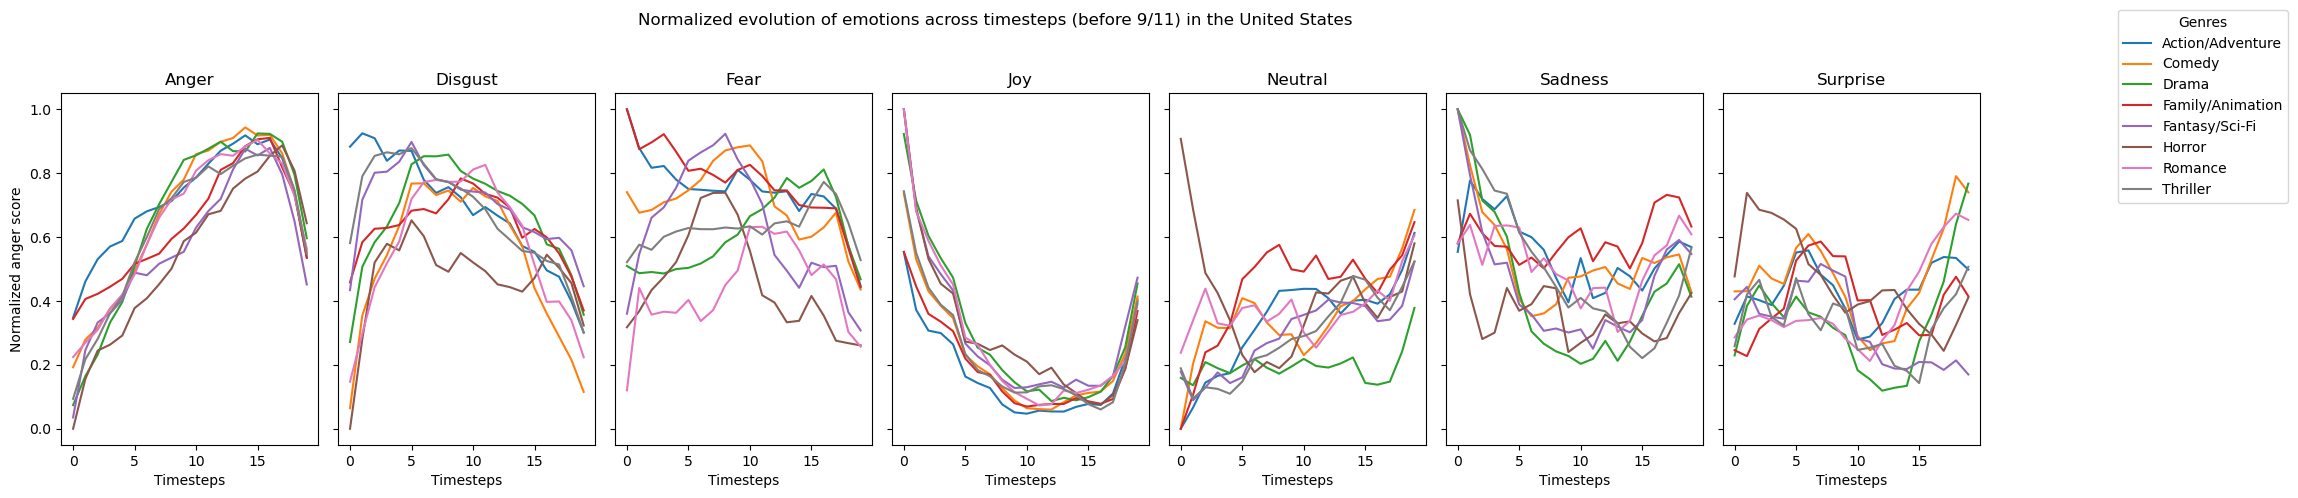

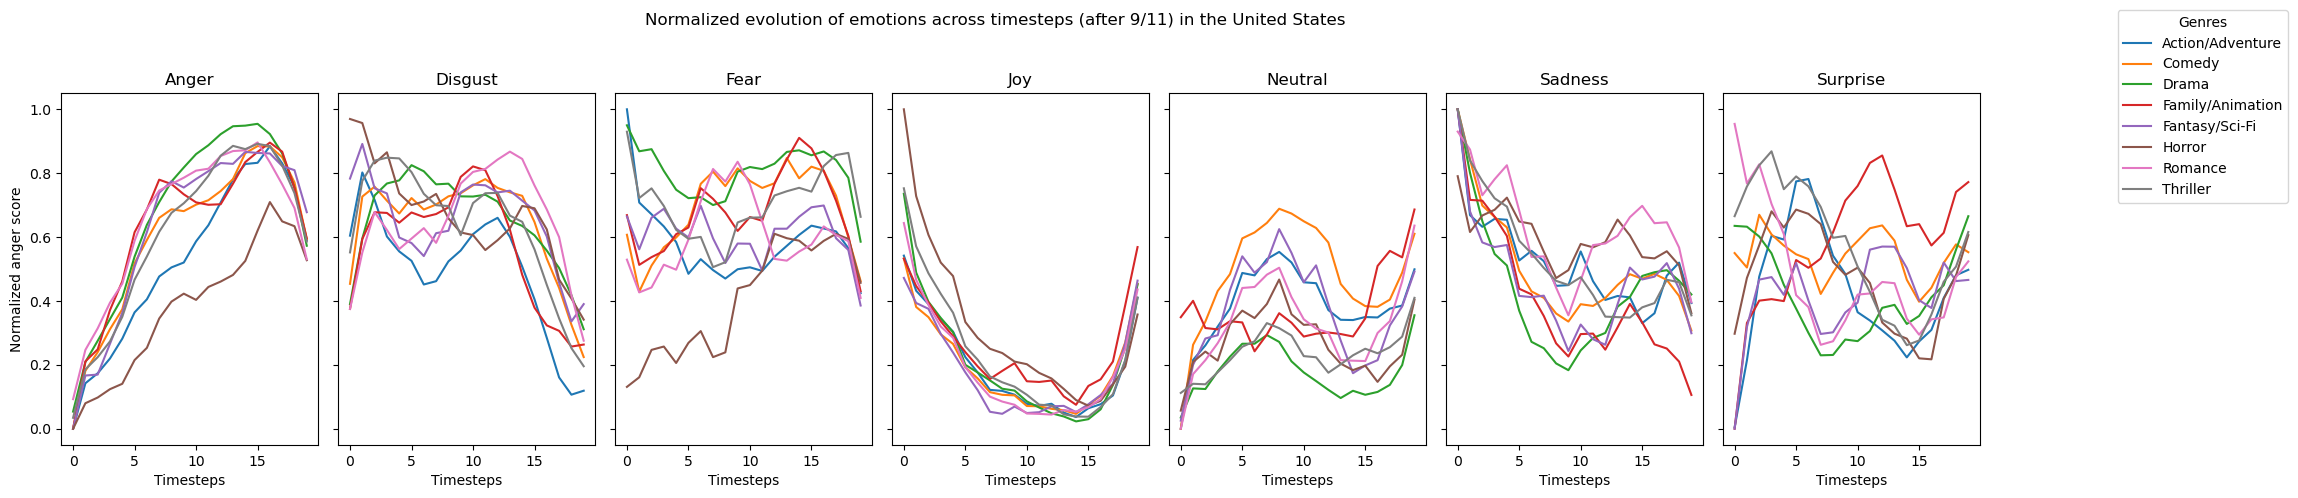

In [203]:
# Define a dictionary to loop over the two periods
datasets = {
    "before 9/11": df_before_911,
    "after 9/11": df_after_911
}

# Create plots for each dataset divided by category
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized evolution of emotions across timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion} score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



If we look closely we notice a change for sadness, let's dig into that, especially for romance and family/animation

In [ ]:
# Update the datasets to include only "Romance" and "Family/Animation" for "Sadness"
categories_of_interest = ["Romance", "Family/Animation"]
emotion_of_interest = "sadness"

datasets = {
    "before 9/11": df_before_911,
    "after 9/11": df_after_911
}

# Predefine colors for genres
genre_colors = {
    "Romance": "#E85D75",  # Tomato Red
    "Family/Animation": "#FFAA66"  # Medium Purple
}

# Create subplots with 1 row and 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[f"Evolution of sadness {period}" for period in datasets.keys()]
)

# Loop through the datasets and add traces to each subplot
for i, (period_name, df_period) in enumerate(datasets.items(), start=1):
    # Filter and normalize data for the selected categories
    filtered_data = df_period.loc[categories_of_interest, emotion_of_interest].reset_index()
    pivoted_data = filtered_data.pivot(index="timestep", columns="category", values=emotion_of_interest)
    normalized_data = pivoted_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

    # Add traces to the subplot
    for genre in categories_of_interest:
        fig.add_trace(
            go.Scatter(
                x=normalized_data.index,
                y=normalized_data[genre],
                mode='lines',
                name=genre,
                line=dict(color=genre_colors[genre]),
                legendgroup=genre,  
                showlegend=(i == 1)
            ),
            row=1, col=i
        )

# Update layout for the combined figure
fig.update_layout(
    title="Comparison of sadness evolution before and after 9/11",
    xaxis_title="Timesteps",
    yaxis_title="Normalized sadness score",
    legend_title="Genres",
    template="plotly_white",
    height=400,
    width=1000,
    showlegend=True
)

# Show the plot and save it
fig.show()

fig.write_html("C:/Users/papad/Documents/EPFL/MA 1/ADA/projet/ada-datastory/dataffoneurs-story/assets/plots_alix/before_after_911.html")